In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [5]:
factors = ["AMZN","AAPL","NVDA","META","TSLA","GOOGL","MSFT"]
market.connect()
db.cloud_connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()
factors_df = pd.concat(factors_df).pivot_table(index="date",columns="ticker",values="adjclose")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.78it/s]


In [6]:
spy = spy.merge(factors_df,on="date",how="left")

In [7]:
spy["y"] = spy["spy"].shift(-5)
model = XGBRegressor()
model.fit(spy.iloc[:262][factors],spy.iloc[:262]["y"])
spy["spy_prediction"] = model.predict(spy[factors])
spy["expected_market_return"] = (spy["spy_prediction"] - spy["spy"]) / spy["spy"]

In [29]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(spy[["date","spy","expected_market_return"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["average_return"] = price["adjclose"].pct_change(5).rolling(100).mean()
        price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
        price["historical_return"] = price["adjclose"].pct_change(5)
        price["factor_return"] = price["spy"].pct_change(5)
        price["cov"] = price["factor_return"].rolling(100).cov(price["historical_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_market_return"] - price["rf"])
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:06<00:00, 78.48it/s]


In [30]:
sim = pd.concat(prices)
sim = sim[sim["date"]>datetime(2024,1,1)]
sim["quarter"] = [x.quarter for x in sim["date"]]

In [71]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 7):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional)
                            position["stocks"][j] = stock
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional)
                        position["stocks"][j] = stock
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [72]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [73]:
for state in states:
    try:
        state["stock_pv"] = sum([sum([state["positions"][i]["stocks"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"]
    except Exception as e:
        print(str(e))
        continue

In [74]:
performance = pd.DataFrame(states).dropna()
performance["stock_return"] = (performance["stock_pv"] - performance["stock_pv"].iloc[0]) / performance["stock_pv"].iloc[0]
performance["return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

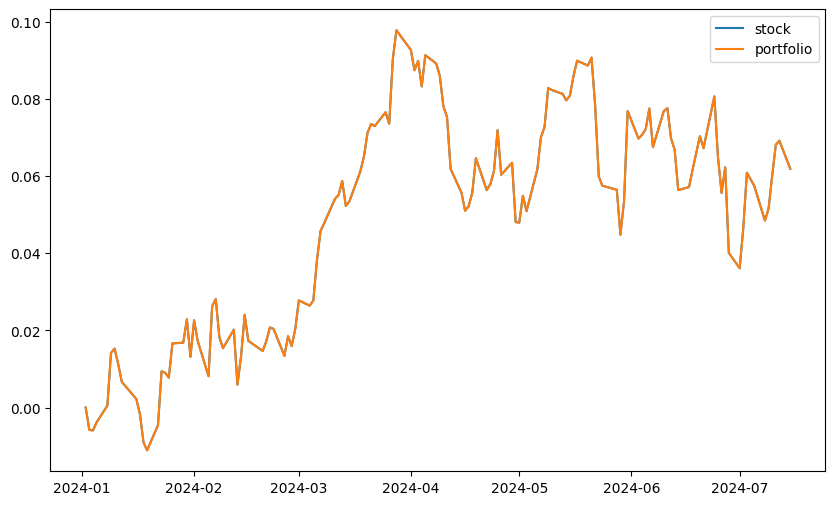

In [75]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.plot(performance["date"].values,performance["return"].values)
plt.legend(["stock","portfolio"])

In [76]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [77]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

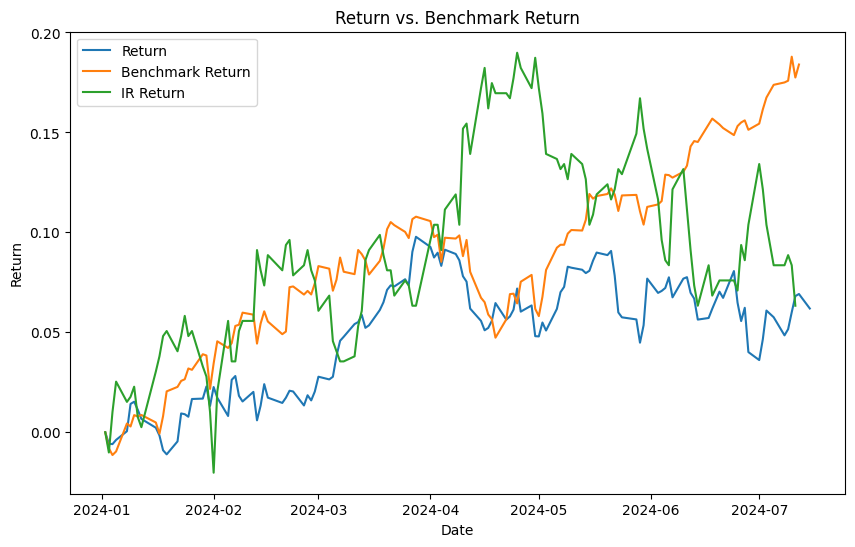

In [78]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [79]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

np.float64(nan)

In [80]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [81]:
t.sort_values("return",ascending=False).head(10)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,GICS Sector,return,hpr
2,JNPR,37.59,309.846936,-0.233391,29.34,2024-01-02,2024-01-10,11647.146310,Information Technology,0.281186,8
239,PARA,11.81,1025.983309,0.272012,9.97,2024-06-26,2024-07-05,12116.862880,Communication Services,0.184554,9
49,DD,66.84,138.492487,-0.138174,61.21,2024-02-05,2024-02-13,9256.837831,Materials,0.091978,8
30,VZ,42.40,233.819678,0.018828,38.94,2024-01-18,2024-01-26,9913.954358,Communication Services,0.088855,8
148,NEM,42.26,258.542261,-0.015564,39.02,2024-04-19,2024-04-29,10925.995936,Materials,0.083034,10
86,DG,157.31,66.887312,0.414471,145.31,2024-02-29,2024-03-08,10522.042993,Consumer Staples,0.082582,8
48,WTW,270.86,40.510475,-0.022198,250.46,2024-02-05,2024-02-13,10972.667229,Financials,0.081450,8
62,WELL,94.25,100.741457,-0.468167,87.27,2024-02-13,2024-02-21,9494.882334,Real Estate,0.079982,8
24,FTNT,66.12,188.299750,-0.288731,61.41,2024-01-18,2024-01-26,12450.379459,Information Technology,0.076698,8
158,ACGL,98.21,125.533523,0.248570,91.25,2024-04-29,2024-05-07,12328.647268,Financials,0.076274,8


In [82]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return")

,GICS Sector,return,hpr
1,Consumer Discretionary,-0.015073,8.478261
5,Health Care,-0.011833,8.478261
6,Industrials,-0.004413,8.478261
7,Information Technology,-0.003981,8.478261
10,Utilities,0.001251,8.478261
2,Consumer Staples,0.005104,8.478261
9,Real Estate,0.005661,8.478261
8,Materials,0.009954,8.478261
3,Energy,0.010647,8.478261
0,Communication Services,0.012832,8.478261
